In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes
import pickle
from dateutil import parser
from datetime import date as dt
from datetime import timedelta
from scipy import log,exp,sqrt,stats
from copy import deepcopy
import itertools
print('Packages')

Packages


In [2]:
def max_drawdown(series):
    i = np.argmax(np.maximum.accumulate(series) - series) # end of the period
    j = np.argmax(series[:i]) # start of period
    dd = series[j] - series[i]
    dd_perc = ((series[j] - series[i])/series[j])*100
    
    return dd_perc, j, i

In [3]:
# Importing pickle file
# data1 = np.load('latest_coin_data.pkl')
# data2 = np.load('additional_data.pkl')
data = np.load('coin_data_sept.pkl')

# Removing July dates from data1
# data1 = data1.drop(data1.columns[0:4], axis = 1)

# Combining the two dataframes
# data = pd.concat([data2, data1], axis = 1, join = 'outer', sort = True)

# Filling Nan values with 0
data = data.dropna()

# Saving original date index
date_index = data.columns

print('Loading of Data')
print('shape of data: ', data.shape)

Loading of Data
shape of data:  (119, 1005)


In [4]:
print('Getting Market Caps')
# Initialize a close_price list
mc_list = list()
# Making a list of all close_prices
for date in data.index:
    for column in data.columns:
        mc_list.append(data[column][date]['market_cap'])

Getting Market Caps


In [5]:
print('Making Market Cap dataframe')
# Splitting list into 133 lists (one per coin)
mc_list = [mc_list[i:i + data.shape[1]] for i  in range(0, len(mc_list), data.shape[1])]   
# Making dataframe
mc_data = pd.DataFrame(data = mc_list, index = data.index, columns = data.columns)
print(mc_data)

Making Market Cap dataframe
                   Oct 01, 2018  Sep 30, 2018  Sep 29, 2018  Sep 28, 2018  \
1337coin           1.850058e+06  2.045053e+06  1.897168e+06  1.962437e+06   
adzcoin            4.582890e+05  4.637780e+05  4.216300e+05  4.182230e+05   
aeon               9.689881e+06  9.769021e+06  1.030627e+07  1.000837e+07   
anarchistsprime    2.900000e+03  3.190000e+03  3.205000e+03  2.935000e+03   
artbyte            2.243482e+06  2.292016e+06  2.201522e+06  2.208744e+06   
audiocoin          6.747790e+05  7.335020e+05  6.763360e+05  7.415660e+05   
auroracoin         3.494178e+06  3.676552e+06  3.791930e+06  3.845244e+06   
bata               1.900820e+05  1.492070e+05  1.838780e+05  1.717750e+05   
bean-cash          8.636709e+06  7.773088e+06  7.632270e+06  7.862593e+06   
bitbay             1.776522e+07  1.749502e+07  1.733897e+07  1.790729e+07   
bitcoin            1.145097e+11  1.142344e+11  1.148857e+11  1.154895e+11   
bitcrystals        2.369735e+06  2.447012e+06  2

In [6]:
print(mc_data.columns)

Index(['Oct 01, 2018', 'Sep 30, 2018', 'Sep 29, 2018', 'Sep 28, 2018',
       'Sep 27, 2018', 'Sep 26, 2018', 'Sep 25, 2018', 'Sep 24, 2018',
       'Sep 23, 2018', 'Sep 22, 2018',
       ...
       'Jan 10, 2016', 'Jan 09, 2016', 'Jan 08, 2016', 'Jan 07, 2016',
       'Jan 06, 2016', 'Jan 05, 2016', 'Jan 04, 2016', 'Jan 03, 2016',
       'Jan 02, 2016', 'Jan 01, 2016'],
      dtype='object', length=1005)


In [7]:
print('Getting Close Prices')
# Initialize a close_price list
cp_list = list()
# Making a list of all close_prices
for date in data.index:
    for column in data.columns:
        cp_list.append(data[column][date]['close_price'])

Getting Close Prices


In [8]:
print('Making Close Price dataframe')
# Splitting list into 133 lists (one per coin)
cp_list = [cp_list[i:i + data.shape[1]] for i  in range(0, len(cp_list), data.shape[1])]   
# Making dataframe
close_data = pd.DataFrame(data = cp_list, index = data.index, columns = data.columns)

Making Close Price dataframe


In [9]:
print('flipping the dates in order')
# Reording the date index
close_data = close_data[close_data.columns[::-1]]
mc_data = mc_data[mc_data.columns[::-1]]
data = data[data.columns[::-1]]

flipping the dates in order


In [10]:
print('Share cap functions')

def share_cap_recurse(market_cap_list, num_coins, cap_ceiling_amount, final_cap_list):
    not_realloc_val = 0
    realloc_val = 0
    num_final = 0
    new_market_cap_list = []

    for i in range(0, len(market_cap_list)):
        if(market_cap_list[i] > cap_ceiling_amount):
            final_cap_list.append(cap_ceiling_amount)
            realloc_val += market_cap_list[i] - cap_ceiling_amount
            num_final += 1

        else:
            not_realloc_val += market_cap_list[i]

    if(num_final!=0):
        new_market_cap_list = [x * (1+(realloc_val/not_realloc_val)) for x in market_cap_list[num_final:]]
    else:
        new_market_cap_list = deepcopy(market_cap_list)

    
    if len(final_cap_list) == num_coins:
        return
    elif (new_market_cap_list[0] <= cap_ceiling_amount): #assumes ordered desc in market cap
        for cap in new_market_cap_list:
            final_cap_list.append(cap)
        return       

    else:
        share_cap_recurse(new_market_cap_list, num_coins, cap_ceiling_amount, final_cap_list)

def share_cap(market_cap_list, cap_ceiling_percent):  #CHANGE CAP CEILING HERE
    total_cap = sum(market_cap_list)
    cap_ceiling_amount = total_cap * cap_ceiling_percent
    final_cap_list = []
    share_cap_recurse(market_cap_list, len(market_cap_list), cap_ceiling_amount, final_cap_list)

    return (final_cap_list)

Share cap functions


In [11]:
minimum_rebalance_interval = 7
windows = []
num_windows = 60
window_length = 12*28
window_stride = 4
startDate = dt(2017, 1, 1) #- enddate 14th aug 2017 with 105 175 windows or 6 jan with 50
endDate = startDate + timedelta(days=((num_windows-1)*window_stride))
+ timedelta(days=window_length)

if(window_length % minimum_rebalance_interval != 0):
    print("Warning: window length is not divisible by the rebalancing interval")
    
for i in range(num_windows):  
        windows.append(([i*window_stride
                        + x for x in range(0, window_length+1)][0],
                       [i*window_stride
                        + x for x in range(0, window_length+1)][-1]))
str_windows = []

for pair in windows:
    new_pair_1 = (startDate + timedelta(pair[0])).strftime("%b %d, %Y")
    new_pair_2 = (startDate + timedelta(pair[1])).strftime("%b %d, %Y")
    str_windows.append((new_pair_1, new_pair_2))

print(window_length)
print(len(str_windows))
print(str_windows)

336
60
[('Jan 01, 2017', 'Dec 03, 2017'), ('Jan 05, 2017', 'Dec 07, 2017'), ('Jan 09, 2017', 'Dec 11, 2017'), ('Jan 13, 2017', 'Dec 15, 2017'), ('Jan 17, 2017', 'Dec 19, 2017'), ('Jan 21, 2017', 'Dec 23, 2017'), ('Jan 25, 2017', 'Dec 27, 2017'), ('Jan 29, 2017', 'Dec 31, 2017'), ('Feb 02, 2017', 'Jan 04, 2018'), ('Feb 06, 2017', 'Jan 08, 2018'), ('Feb 10, 2017', 'Jan 12, 2018'), ('Feb 14, 2017', 'Jan 16, 2018'), ('Feb 18, 2017', 'Jan 20, 2018'), ('Feb 22, 2017', 'Jan 24, 2018'), ('Feb 26, 2017', 'Jan 28, 2018'), ('Mar 02, 2017', 'Feb 01, 2018'), ('Mar 06, 2017', 'Feb 05, 2018'), ('Mar 10, 2017', 'Feb 09, 2018'), ('Mar 14, 2017', 'Feb 13, 2018'), ('Mar 18, 2017', 'Feb 17, 2018'), ('Mar 22, 2017', 'Feb 21, 2018'), ('Mar 26, 2017', 'Feb 25, 2018'), ('Mar 30, 2017', 'Mar 01, 2018'), ('Apr 03, 2017', 'Mar 05, 2018'), ('Apr 07, 2017', 'Mar 09, 2018'), ('Apr 11, 2017', 'Mar 13, 2018'), ('Apr 15, 2017', 'Mar 17, 2018'), ('Apr 19, 2017', 'Mar 21, 2018'), ('Apr 23, 2017', 'Mar 25, 2018'), ('Apr 

In [12]:
# final_dict_list = 
# tether_cap_values = [0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
# asset_cap_values = [0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
# mc_gearing_values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

tether_cap_values = [0.50, 1]
asset_cap_values = [0.15, 0.20]
mc_gearing_values_up = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
mc_gearing_values_down = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# tether_cap_list = [("tcap", x) for x in tether_cap_values]
# asset_cap_list = [("acap", x) for x in asset_cap_values]
# mc_gearing_list = [("mcg", x) for x in mc_gearing_values]

tether_cap_list = [("tcap", x) for x in tether_cap_values]
asset_cap_list = [("acap", x) for x in asset_cap_values]
mc_gearing_list_up = [("mcgu", x) for x in mc_gearing_values_up]
mc_gearing_list_down = [("mcgd", x) for x in mc_gearing_values_down]

# spec_lists = [tether_cap_list, asset_cap_list, mc_gearing_list]
spec_lists = [tether_cap_list, asset_cap_list, mc_gearing_list_down, mc_gearing_list_up]
 
final_dict_list = list(itertools.product(*spec_lists))

print(len(final_dict_list))
print(final_dict_list)

# final_dict_list = [(('tcap', 0), ('acap', 0.15), ('mcg', 3)),
#                    (('tcap', 0.25), ('acap', 0.15), ('mcg', 3)),
#                    (('tcap', 0.50), ('acap', 0.15), ('mcg', 3)), 
#                    (('tcap', 0.75), ('acap', 0.15), ('mcg', 3)), 
#                    (('tcap', 1), ('acap', 0.15), ('mcg', 3)),
#                   (('tcap', 1), ('acap', 0.15), ('mcg', 0.5)),
#                   (('tcap', 1), ('acap', 0.15), ('mcg', 0))]

final_dict_list = [(('tcap', 0.5), ('acap', 0.15), ('mcg', 0.5)),
                   (('tcap', 1), ('acap', 0.15), ('mcgd', 1.5), ('mcgu', 1)), 
                   (('tcap', 1), ('acap', 0.2), ('mcgd', 2), ('mcgu', 1)),
                  (('tcap', 0), ('acap', 1), ('mcgd', 0), ('mcgu', 0))]

# final_dict_list = [(('tcap', 0.5), ('acap', 0.15), ('mcg', 0.5)),
#                   (('tcap', 0), ('acap', 1), ('mcgd', 0), ('mcgu', 0))]

400
[(('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 0.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 1)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 1.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 2)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 2.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 3)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 3.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 4)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 4.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 0.5), ('mcgu', 5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 0.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 1)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 1.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 2)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 2.5)), (('tcap', 0.5), ('acap', 0.15), ('mcgd', 1), ('mcgu', 3)), (('tcap', 0.5),

In [13]:
tether_multiplier = 0
single_asset_cap_ceiling = 0.15
max_tether_cap = 0.3
usdt_share = {}
usdt_share[0] = 0     #USDT starts off with ___% for the date
start_date = 'Jan 01, 2017'
end_date = 'Sep 30, 2018'

In [14]:
def toTitle(graph):
    if graph[2][0] == "mcg":
        return((graph[0][0] + ":" + str(graph[0][1]) + "_" + graph[1][0] + ":" + str(graph[1][1]) + "_" + graph[2][0] + ":" + str(graph[2][1])))
    else:
        return (graph[0][0] + ":" + str(graph[0][1]) + "_" + graph[1][0] + ":" + str(graph[1][1]) + "_" + graph[2][0] + ":" + str(graph[2][1]) + "_" + graph[3][0] + ":" + str(graph[3][1]))  

In [15]:
#////////////////////////////////////////////////////////////////////////////////////////////
# Selecting dates and median market caps
selectedmarket = mc_data.copy()
selectedmarketfull = (selectedmarket.loc[:, start_date:end_date]).copy()
selectedmarket = selectedmarket.loc[:, start_date:end_date:7]
# selectedmarket = selectedmarket.resample('W',axis=1).median()
# print(selectedmarketfull)

# Selecting dates and median close price
selectedclose = close_data.copy()
selectedclosefull = selectedclose.loc[:, start_date:end_date]
selectedclose = selectedclose.loc[:, start_date:end_date:7]
# selectedclose = selectedclose.resample('W',axis=1).median()

bitcoin = pd.DataFrame(data=selectedclosefull.T["bitcoin"], columns = ["bitcoin"])

pct_bitcoin = bitcoin.pct_change(1)
pct_bitcoin["bitcoin"] = (1 + pct_bitcoin["bitcoin"]).cumprod()

# pct_bitcoin["bitcoin"].iloc[0] = 1
pct_bitcoin.at[start_date, "bitcoin"] = 1
# print(pct_bitcoin)

# Daily close prices
dailyclose = close_data.loc[:,start_date:end_date]
dailyclose1 = dailyclose.copy().T
dailychanget = dailyclose1.pct_change(1).T
dailychange = dailyclose1.pct_change(1).T

# Calculating percent change for returns
selectedclose1 = selectedclose.copy().T
selectedreturns = selectedclose1.pct_change(1) .T
selectedreturns.head()
#     print('selected market, selectedclose, dailychange and selectedreturns')

#     print('Total market cap movement for tethershare')
tmc_list = list()

#weekly

for column in selectedmarket.columns:
    tmc_list.append(selectedmarket[column].sum())
    
# print(selectedmarket[selectedmarket.columns[1][:20]])

tmc_data = pd.DataFrame(data = tmc_list, columns = ['total_mc'])
tmc_data.index = selectedmarket.columns
tmc_pct = tmc_data.pct_change(1)

tmc_list_full = []
#full set
for column in selectedmarketfull.columns:
    tmc_list_full.append(selectedmarketfull[column].sum())

tmc_data_full = pd.DataFrame(data = tmc_list_full, columns = ['TMC'])
tmc_data_full.index = selectedmarketfull.columns
tmc_pct_full = tmc_data_full.pct_change(1)

# print(tmc_data_full)

tmc_pct_full["TMC"] = (1 + tmc_pct_full["TMC"]).cumprod()
tmc_pct_full.at[start_date, "TMC"] = 1

# for entry in tmc_pct_full["TMC"]:
#     print(entry)

# Resampling the tmc data to get weekly
#     print(tmc_pct)
tmc_pct = tmc_pct.loc[start_date:end_date,:]

# tmc_pct = tmc_pct.resample('W').median()
tmc_pct_index = tmc_pct.index

# print(tmc_pct)

print(len(tmc_pct_index), "full weeks in period")

num_index = np.arange(len(tmc_pct_index))
tmc_pct.index = num_index

92 full weeks in period


In [16]:
def sortino(series, column):
    fullMean = series.mean()[column]
    queryStr = "{} < {}".format(column, str(fullMean))
    #@ refers to a variable in the environment
    downside_series = series.query(queryStr)
#     print("mean",mean, "ds",downside_series)
    sortino = fullMean/downside_series.std()
    print("monthly downside deviation:", downside_series.std())
    
    return sortino

In [17]:
writer = pd.ExcelWriter('Fund_data.xlsx')

In [18]:
#calculating tmc movements for graphing purposes

0
Calculating: tcap:0.5_acap:0.15_mcg:0.5
***************************************************************
644
vol               c10t_cum
2017-12-31  385.640199
2018-12-31  399.145743
              c10t_cum
2017-01-01   11.305505
2017-02-01   23.713318
2017-03-01  102.907348
2017-04-01   96.446276
2017-05-01  187.605954
2017-06-01   -3.466106
2017-07-01   -6.303870
2017-08-01   82.492548
2017-09-01  -23.440601
2017-10-01   -1.406601
2017-11-01   87.186425
2017-12-01  184.219163
2018-01-01  -24.224189
2018-02-01    0.342764
2018-03-01  -32.809890
2018-04-01   32.161402
2018-05-01  -18.416062
2018-06-01  -15.148075
2018-07-01    1.960156
2018-08-01   -9.466625
2018-09-01         NaN
monthly std c10t_cum    66.987205
dtype: float64
sharpe c10t_cum    0.504319
dtype: float64
monthly downside deviation: c10t_cum    18.291532
dtype: float64
sortino c10t_cum    1.846917
dtype: float64
final 46.1498 4514.98
max 143.7605 14276.050000000001
Max drawdown (71.78625331471409, 'Jan 07, 2018', 'Sep 12

/home/luke/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


vol               c10t_cum
2017-12-31  311.194771
2018-12-31  170.342736
              c10t_cum
2017-01-01    9.878085
2017-02-01   23.174882
2017-03-01   96.518579
2017-04-01   96.446276
2017-05-01  183.639129
2017-06-01   -2.634002
2017-07-01  -12.294333
2017-08-01   73.249102
2017-09-01  -23.819487
2017-10-01   -2.835558
2017-11-01   84.426779
2017-12-01  181.227288
2018-01-01  -14.854561
2018-02-01   -3.108802
2018-03-01   -4.461564
2018-04-01    6.624240
2018-05-01  -10.122707
2018-06-01   -1.549000
2018-07-01   -1.744625
2018-08-01   -1.233897
2018-09-01         NaN
monthly std c10t_cum    63.480218
dtype: float64
sharpe c10t_cum    0.532863
dtype: float64
monthly downside deviation: c10t_cum    11.31083
dtype: float64
sortino c10t_cum    2.990611
dtype: float64
final 60.3888 5938.88
max 112.0713 11107.13
Max drawdown (46.89534867881805, 'Jan 07, 2018', 'Sep 17, 2018')
2
asymmetric
Calculating: tcap:1_acap:0.2_mcgd:2_mcgu:1
********************************************************

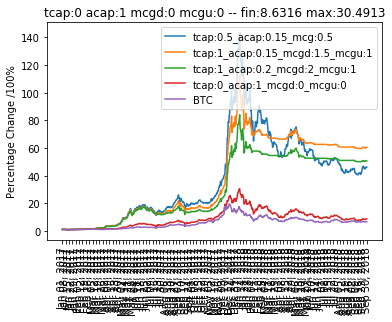

In [19]:
graph_dict = {}
for count, graph in enumerate(final_dict_list):
    print(count)
    
    #     usdt_share = {}
    #     usdt_share[0] = 0.10      #USDT starts off with ___% for the date
    
    max_tether_cap = graph[0][1]
    single_asset_cap_ceiling = graph[1][1]
    
    if graph[2][0] == "mcg":
        tether_multiplier_down = graph[2][1]
        tether_multiplier_up = graph[2][1]
        
    else:
        print("asymmetric")
        tether_multiplier_down = graph[2][1]
        tether_multiplier_up = graph[3][1]
    
    
    print("Calculating: " + toTitle(graph))
    
    print("***************************************************************")
   

    for i in tmc_pct.index[1:]:
        #market down, crypto->tether
        if tmc_pct['total_mc'][i] < -0.01:
            usdt_share[i] = usdt_share[i -1] - tether_multiplier_down*(tmc_pct['total_mc'][i])
            if usdt_share[i] >= max_tether_cap:
                usdt_share[i] = max_tether_cap
                
        #market up, tether->crypto
        elif tmc_pct['total_mc'][i] > 0.01: 
            usdt_share[i] = usdt_share[i -1] - tether_multiplier_up*(tmc_pct['total_mc'][i])
            if usdt_share[i] <= 0:
                usdt_share[i] = 0
        else:
            usdt_share[i] = usdt_share[i -1]

    ilist = range(0, len(tmc_pct))

    tethershare = {}

    for (i, column) in zip(ilist, selectedmarket):
        tethershare[column] = usdt_share[i]

#     print('setting tethershare labels to match dates')

#     print('usdt_close prices and usdt_retruns (pct change)')
    usdt_close = pd.DataFrame(data = dailyclose.loc['tether'])
    usdt_returns = usdt_close.pct_change(1)
    usdt_returns.head(5)


    # single_asset_cap_ceiling = 0.15
#     print('loop for C10 with tether market cap function')
    #FOR LOOP FOR C10 with tether
    topmc10t = {}
    sc10t = {}
    tc10t = {}
    ps10t = {}
    invest10t = {}
    returns10t = {}
    lg_returns10t = {}
    selectedmc10t = {}
    topcoins10t = {}
    c10sharet = {}
    usdt_returnst = {}
    daily_usdt_returnst = {}

    daily_changet = {}
    weighted_daily_changet = {}
    daily_returnst = {}
    c10t_returns = list()
    tether_returns = list()


    #for every date
#     print(len(selectedmarket), "selectdmrkrk")
    for column in selectedmarket:
        #sort in descending order
        selectedmc10t[column] = selectedmarket[column].sort_values(ascending=False)

        #take the top coins
        topmc10t[column] = selectedmc10t[column].head(10)
        #take the index of the top coins
        topcoins10t[column] = topmc10t[column].index

        #get the share cap of the top 10
        sc10t[column] = share_cap(topmc10t[column], single_asset_cap_ceiling)      #CHOICE OF CAP CEILING

        #total cap of top 10
        tc10t[column] = sum(sc10t[column])

        #percentage of total fund allocated to tether/C10- NEW CODE!!
        c10tfund = 1 - tethershare[column]

        #percentage share to be allocated for top 10 - NEW CODE!!!
        ps10t[column] = [x * c10tfund / tc10t[column] for x in sc10t[column] ]

        #building dataframe of top20 coins by mc and %share to be invested
        invest10t[column] = pd.DataFrame()
        invest10t[column] = pd.DataFrame({'coin': topcoins10t[column], 'pct_share': ps10t[column]})
        invest10t[column] = invest10t[column].set_index('coin')

    print(len(tmc_pct)*7)
    jlist = list(range(0,len(tmc_pct)*7,7))

    for (j, column) in zip(jlist, selectedmarket):
        daily_changet[column] = pd.DataFrame()
        daily_changet[column] = pd.DataFrame(data = dailychanget.iloc[:,j:j+7])
        daily_changet[column] = daily_changet[column].loc[topcoins10t[column]]
        weighted_daily_changet[column] = daily_changet[column].mul(ps10t[column], axis=0)

        daily_returnst[column] = weighted_daily_changet[column].sum()
        daily_returnst[column].columns = ['daily_returns']

        usdt_returnst[column] = pd.DataFrame()
        usdt_returnst[column] = pd.DataFrame(data = usdt_returns.iloc[j:j+7,:])
        daily_usdt_returnst[column] = usdt_returnst[column].mul(tethershare[column], axis = 0)

        c10t_returns.extend(daily_returnst[column])
        tether_returns.extend(daily_usdt_returnst[column]['tether'])

    #////////////////////////////////////////
#     print(c10t_returns)
#     print(len(c10t_returns))
    c10t_returns_df = pd.DataFrame(data = c10t_returns, index = dailychanget.columns, columns = ['c10t'])

    c10t_returns_df['tether'] = tether_returns
    c10t_returns_df['c10t+tether'] = c10t_returns_df['c10t']

    c10t_returns_df.head(5)
    c10t_returns_df['c10t_cum'] = (1 + c10t_returns_df['c10t+tether']).cumprod()
    c10t_returns_df.head(5)
#     print(tmc_pct_full)
    c10t_returns_df.at[start_date,'c10+tether'] = 1
    c10t_returns_df.at[start_date,'c10t_cum'] = 1
    c10t_returns_df.head(10)
    c10t_returns_df['c10t+tether'].std(axis = 0)

    tether_allocations = pd.DataFrame(data = tethershare, index = tethershare.keys())
    tether_allocations = tether_allocations.drop(tether_allocations.index[1:])
    tether_allocations = tether_allocations.T
    tether_allocations.columns = ['tether_share']
#     tether_allocations.head(5)
#     print(tether_allocations)

    # print('Monthly returns growth')
    # Resampling the returns by month
    daily_returns = pd.DataFrame(data = c10t_returns_df['c10t_cum'])
#     print("dfsfsfs", daily_returns)
    daily_returns.index = pd.to_datetime(daily_returns.index)
    monthly_df = daily_returns.resample('MS').asfreq()
    monthly_df2 = (monthly_df - monthly_df.shift(1))/monthly_df.shift(1)
    monthly_df2 = monthly_df2.shift(-1)*100
    
    volatility = daily_returns.resample('Y').std()*math.sqrt(365)
    
    print("vol", volatility)
    print(monthly_df2)
    
    sharpe = monthly_df2.mean()/monthly_df2.std()
    print("monthly std", monthly_df2.std())
    print("sharpe", sharpe)
    print("sortino", sortino(monthly_df2, "c10t_cum"))
    
#     ax = daily_returns.plot.kde()
#     plt.show()
    
    graphmax = round(((c10t_returns_df[c10t_returns_df['c10t_cum']==c10t_returns_df['c10t_cum'].max()])["c10t_cum"]).iloc[0],4)
    graphfinal = round(c10t_returns_df["c10t_cum"].iloc[-1], 4)
    print("final", graphfinal, (graphfinal-1)*100)
    print("max", graphmax, (graphmax-1)*100)
    
    c10t_returns_df.to_excel(writer, toTitle(graph).replace(":","").replace("_","") + ".xlsx")

    plt.ylabel('Percentage Change /100%')
    plt.rcParams['figure.figsize'] = (30,15)   
    plt.plot(c10t_returns_df['c10t_cum'], label=toTitle(graph))
    max_dd, start, end = max_drawdown(c10t_returns_df['c10t_cum'])
    print("Max drawdown", max_drawdown(c10t_returns_df['c10t_cum']))
    
    #Add dots indicating beginning and end of the maximum drawdown period
#     plt.plot([start, end], [c10t_returns_df['c10t_cum'][start], c10t_returns_df['c10t_cum'][end]], 'o', color='Red', markersize=10)
    
    plt.xticks(np.arange(0,len(c10t_returns_df),step=7), rotation=90)
    plt.title(toTitle(graph).replace("_", " ") + " --" + " fin:" + str(graphfinal) + " max:" + str(graphmax))
#     plt.ylim(0, 180)
    
    #/////////////////////////////////
#     plt.legend()
#     plt.savefig('tether_graphs_asymmetric/' + toTitle(graph) + ".png", dpi=100)
    
#     plt.clf()
#     plt.cla()
#     plt.close()


# plt.plot(tmc_pct_full['TMC'], label="TMC")
# plt.xticks(np.arange(0,len(tmc_pct_full),step=7), rotation=90)

plt.plot(pct_bitcoin['bitcoin'], label="BTC")
plt.xticks(np.arange(0,len(pct_bitcoin),step=7), rotation=90)

plt.legend()
plt.rcParams['figure.figsize'] = (30,15)
plt.savefig('tether_asymm_comb/' + "combined" + ".png", dpi=100)
plt.show()
writer.save()

In [ ]:
print("Max drawdown", max_drawdown(pct_bitcoin["bitcoin"]))
# print(pct_bitcoin["bitcoin"])
pct_bitcoin.index = pd.to_datetime(pct_bitcoin.index)
volatility = pct_bitcoin.resample('Y').std()*math.sqrt(365)
print(volatility)
monthly_btc = pct_bitcoin.resample('MS').asfreq()
monthly_btc2 = (monthly_btc - monthly_btc.shift(1))/monthly_btc.shift(1)
monthly_btc2 = monthly_btc2.shift(-1)*100
print("Monthly BTC", monthly_btc2)
print("sharpe", monthly_btc2.mean()/monthly_btc2.std())
print("monthly standard deviation", monthly_btc2.std())
print("sortio", sortino(monthly_btc2, "bitcoin"))
graphmax = round(((pct_bitcoin[pct_bitcoin['bitcoin']==pct_bitcoin['bitcoin'].max()])["bitcoin"]).iloc[0],4)
graphfinal = round(pct_bitcoin["bitcoin"].iloc[-1], 4)
print(graphmax, graphfinal)

In [ ]:
plt.ylabel('Percentage Change /100%')
plt.rcParams['figure.figsize'] = (30,15)
plt.plot(c10t_returns_df['c10t_cum'], label="C10 w/Tether")
plt.xticks(np.arange(0,len(c10t_returns_df),step=7), rotation=90)
plt.title('C10 vs C10 w/Tether (market cap)')
plt.legend()
fig.savefig('', dpi=100)


In [ ]:
wins_dict = {"c10_cum": [], "c10t_cum": []}
summary_dict = {"c10_cum": 0, "c10t_cum": 0}
#dtest.strftime("%b %d, %Y")

#iterates through periods
for count, pair in enumerate(str_windows):
    start_date = pair[0]
    end_date = pair[1]
    
    print(start_date, end_date)
    
#     start_date_dt = datetime.strptime(start_date, "%b %d, %Y").date()
#     end_date_dt = datetime.strptime(end_date, "%b %d, %Y").date()
    
#     print(start_date, end_date, start_date_dt, end_date_dt)
    
    #////////////////////////////////////////////////////////////////////////////////////////////
    # Selecting dates and median market caps
    selectedmarket = mc_data.copy()
    selectedmarket = selectedmarket.loc[:, start_date:end_date:7]
    # selectedmarket = selectedmarket.resample('W',axis=1).median()

    # Selecting dates and median close price
    selectedclose = close_data.copy()
    selectedclose = selectedclose.loc[:, start_date:end_date:7]
    # selectedclose = selectedclose.resample('W',axis=1).median()

    # Daily close prices
    dailyclose = close_data.loc[:,start_date:end_date]
    dailyclose1 = dailyclose.copy().T
    dailychanget = dailyclose1.pct_change(1).T
    dailychange = dailyclose1.pct_change(1).T

    # Calculating percent change for returns
    selectedclose1 = selectedclose.copy().T
    selectedreturns = selectedclose1.pct_change(1).T
    selectedreturns.head()
    print('selected market, selectedclose, dailychange and selectedreturns')

    print('Total market cap movement for tethershare')
    tmc_list = list()

    for column in selectedmarket.columns:
        tmc_list.append(selectedmarket[column].sum())

    tmc_data = pd.DataFrame(data = tmc_list, columns = ['total_mc'])
#     print(tmc_data)
    tmc_data.index = selectedmarket.columns
    tmc_pct = tmc_data.pct_change(1)
#     print(tmc_pct)

    # Resampling the tmc data to get weekly
    tmc_pct = tmc_pct.loc[start_date:end_date,:]
    # tmc_pct = tmc_pct.resample('W').median()
    tmc_pct_index = tmc_pct.index

    tmc_pct.head(5)

    print('tether share allocations per week')
    tether_multiplier = 0
    max_tether_cap = 0.3
    
    print(len(tmc_pct_index), "full weeks in period")

    num_index = np.arange(len(tmc_pct_index))
    tmc_pct.index = num_index

#     usdt_share = {}
#     usdt_share[0] = 0.10      #USDT starts off with ___% for the date


    for i in tmc_pct.index[1:]:
        if tmc_pct['total_mc'][i] < -0.01:
            usdt_share[i] = usdt_share[i -1] - tether_multiplier*(tmc_pct['total_mc'][i])
            if usdt_share[i] >= max_tether_cap:
                usdt_share[i] = max_tether_cap
        elif tmc_pct['total_mc'][i] > 0.01: 
            usdt_share[i] = usdt_share[i -1] - tether_multiplier*(tmc_pct['total_mc'][i])
            if usdt_share[i] <= 0:
                usdt_share[i] = 0
        else:
            usdt_share[i] = usdt_share[i -1]

    ilist = range(0, len(tmc_pct))

    tethershare = {}

    for (i, column) in zip(ilist, selectedmarket):
        tethershare[column] = usdt_share[i]

    print('setting tethershare labels to match dates')


    print('usdt_close prices and usdt_retruns (pct change)')
    usdt_close = pd.DataFrame(data = dailyclose.loc['tether'])
    usdt_returns = usdt_close.pct_change(1)
    usdt_returns.head(5)


    single_asset_cap_ceiling = 0.15
    print('loop for C10 with tether market cap function')
    #FOR LOOP FOR C10 with tether
    topmc10t = {}
    sc10t = {}
    tc10t = {}
    ps10t = {}
    invest10t = {}
    returns10t = {}
    lg_returns10t = {}
    selectedmc10t = {}
    topcoins10t = {}
    c10sharet = {}
    usdt_returnst = {}
    daily_usdt_returnst = {}

    daily_changet = {}
    weighted_daily_changet = {}
    daily_returnst = {}
    c10t_returns = list()
    tether_returns = list()


    #for every date
    for column in selectedmarket:
        #sort in descending order
        selectedmc10t[column] = selectedmarket[column].sort_values(ascending=False)

        #take the top coins
        topmc10t[column] = selectedmc10t[column].head(10)
        #take the index of the top coins
        topcoins10t[column] = topmc10t[column].index

        #get the share cap of the top 10
        sc10t[column] = share_cap(topmc10t[column], single_asset_cap_ceiling)      #CHOICE OF CAP CEILING

        #total cap of top 10
        tc10t[column] = sum(sc10t[column])

        #percentage of total fund allocated to tether/C10- NEW CODE!!
        c10tfund = 1 - tethershare[column]

        #percentage share to be allocated for top 10 - NEW CODE!!!
        ps10t[column] = [x * c10tfund / tc10t[column] for x in sc10t[column] ]

        #building dataframe of top20 coins by mc and %share to be invested
        invest10t[column] = pd.DataFrame()
        invest10t[column] = pd.DataFrame({'coin': topcoins10t[column], 'pct_share': ps10t[column]})
        invest10t[column] = invest10t[column].set_index('coin')
        
    jlist = list(range(0,365,7))

    for (j, column) in zip(jlist, selectedmarket):
        daily_changet[column] = pd.DataFrame()
        daily_changet[column] = pd.DataFrame(data = dailychanget.iloc[:,j:j+7])
        daily_changet[column] = daily_changet[column].loc[topcoins10t[column]]
        weighted_daily_changet[column] = daily_changet[column].mul(ps10t[column], axis=0)

        daily_returnst[column] = weighted_daily_changet[column].sum()
        daily_returnst[column].columns = ['daily_returns']


        usdt_returnst[column] = pd.DataFrame()
        usdt_returnst[column] = pd.DataFrame(data = usdt_returns.iloc[j:j+7,:])
        daily_usdt_returnst[column] = usdt_returnst[column].mul(tethershare[column], axis = 0)

        c10t_returns.extend(daily_returnst[column])
        tether_returns.extend(daily_usdt_returnst[column]['tether'])

    #/////////////////////////////////////////////////////////////////
    print('loop for C10 without tether market cap function')
    #FOR LOOP FOR C10 with tether
    topmc10 = {}
    sc10 = {}
    tc10 = {}
    ps10 = {}
    invest10 = {}
    returns10 = {}
    lg_returns10 = {}
    selectedmc10 = {}
    topcoins10 = {}
    c10share = {}
    usdt_returns = {}
    daily_usdt_returns = {}

    daily_change = {}
    weighted_daily_change = {}
    daily_returns = {}
    c10_returns = list()


    #for every date
    for column in selectedmarket:
        #sort in descending order
        selectedmc10[column] = selectedmarket[column].sort_values(ascending=False)

        #take the top coins
        topmc10[column] = selectedmc10[column].head(10)
        #take the index of the top coins
        topcoins10[column] = topmc10[column].index

        #get the share cap of the top 10
        sc10[column] = share_cap(topmc10[column], single_asset_cap_ceiling)      #CHOICE OF CAP CEILING

        #total cap of top 10
        tc10[column] = sum(sc10[column])

        #percentage share to be allocated for top 10 - NEW CODE!!!
        ps10[column] = [x / tc10[column] for x in sc10[column] ]

        #building dataframe of top20 coins by mc and %share to be invested
        invest10[column] = pd.DataFrame()
        invest10[column] = pd.DataFrame({'coin': topcoins10[column], 'pct_share': ps10[column]})
        invest10[column] = invest10[column].set_index('coin')

    jlist = list(range(0,365,7))

    for (j, column) in zip(jlist, selectedmarket):
        daily_change[column] = pd.DataFrame()
        daily_change[column] = pd.DataFrame(data = dailychange.iloc[:,j:j+7])
        daily_change[column] = daily_change[column].loc[topcoins10[column]]
        weighted_daily_change[column] = daily_change[column].mul(ps10[column], axis=0)

        daily_returns[column] = weighted_daily_change[column].sum()
        daily_returns[column].columns = ['daily_returns']

        c10_returns.extend(daily_returns[column])

    #////////////////////////////////////////////////////////////////////////////////////////////
        
    c10t_returns_df = pd.DataFrame(data = c10t_returns, index = dailychange.columns, 
                                   columns = ['c10t'])
    c10t_returns_df['tether'] = tether_returns
    c10t_returns_df['c10t+tether'] = c10t_returns_df['tether'] + c10t_returns_df['c10t']

    c10t_returns_df['c10'] = c10_returns

    c10t_returns_df.head(5)

    c10t_returns_df['c10t_cum'] = (1 + c10t_returns_df['c10t+tether']).cumprod()
    c10t_returns_df['c10_cum'] = (1 + c10t_returns_df['c10']).cumprod()
    c10t_returns_df.head(5)

    c10t_returns_df.at[start_date,'c10+tether'] = 1
    c10t_returns_df.at[start_date,'c10_cum'] = 1
    c10t_returns_df.at[start_date,'c10t_cum'] = 1
    c10t_returns_df.at[start_date,'c10'] = 1
    c10t_returns_df.head(10)
    c10t_returns_df['c10t+tether'].std(axis = 0)

    tether_allocations = pd.DataFrame(data = tethershare, index = tethershare.keys())
    tether_allocations = tether_allocations.drop(tether_allocations.index[1:])
    tether_allocations = tether_allocations.T
    tether_allocations.columns = ['tether_share']
    tether_allocations.head(5)
    
    print('Monthly returns growth')
    # Resampling the two returns by month
    daily_returns = pd.DataFrame(data = [c10t_returns_df['c10_cum'], 
                                           c10t_returns_df['c10t_cum']],)
    daily_returns.columns = pd.to_datetime(daily_returns.columns)
    daily_returns = daily_returns.T
    monthly_df = daily_returns.resample('MS').asfreq()[0:13]


    monthly_df.head(13)

    print(daily_returns)
    
#     daily_returns_nt = daily_returns.T


    for key in wins_dict.keys():
        wins_dict[key].append(0)

    #iterates over all timesteps for one period
    for index, row in daily_returns.iterrows():
        largest = -10000
        win_key = ""
        
        #This loop compares values of all strats per single timestep
        for key in wins_dict.keys():
            if float(row[key]) > largest:
                largest = float(row[key])
                win_key = key

        wins_dict[win_key][count] += 1 

#     print(wins_dict)
#     print(daily_returns_nt)

In [ ]:
# print('tether share allocations per week')

# num_index = np.arange(53)
# tmc_pct.index = num_index

# usdt_share = {}
# usdt_share[0] = 0.10      #USDT starts off with ___% for the date


# for i in tmc_pct.index[1:]:
#     if tmc_pct['total_mc'][i] < -0.01:
#         usdt_share[i] = usdt_share[i -1] + 0.02
#         if usdt_share[i] >= 1.00:
#             usdt_share[i] = 1.00
#     elif tmc_pct['total_mc'][i] > 0.01: 
#         usdt_share[i] = usdt_share[i -1] - 0.02
#         if usdt_share[i] <= 0:
#             usdt_share[i] = 0
#     else:
#         usdt_share[i] = usdt_share[i -1]

In [ ]:
for i in range(num_windows):
    currmax=-1000
    currkey=""
    for key in wins_dict.keys():

        value = wins_dict[key][i]
        if value>currmax:
            currmax=value
            currkey=key
    
    summary_dict[currkey] += 1
    print(summary_dict, i)

In [ ]:
print(wins_dict)
print(summary_dict)

In [ ]:
plt.ylabel('Percentage Change /100%')
plt.rcParams['figure.figsize'] = (30,15)
plt.plot(c10t_returns_df['c10_cum'], label="C10")
plt.plot(c10t_returns_df['c10t_cum'], label="C10 w/Tether")
plt.xticks(np.arange(0,365,step=7), rotation=90)
plt.title('C10 vs C10 w/Tether (market cap)')
plt.legend()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
ax1.plot(tether_allocations.index, tether_allocations, label = "Tether allocation mc*2")
ax1.set_ylabel('% share allocated to tether')

ax2.plot(c10t_returns_df.index, c10t_returns_df['c10t_cum'], label = "Tether 2x (100% cap)")
ax2.plot(c10t_returns_df.index, c10t_returns_df['c10_cum'], label = "C10")
ax2.set_ylabel('Portfolio cumulative simple returns (%)')


ax2.set_xticks(np.arange(0,365,step=7))

ax1.set_xticklabels(tether_allocations.index ,rotation=90, fontsize = 7)
ax2.set_xticklabels(tether_allocations.index ,rotation=90, fontsize = 7)

labels = [item.get_text() for item in mpl.axes.Axes.get_xticklabels(ax2)]

ax1.legend()
ax2.legend()

plt.show()

In [ ]:
print(freqvals_list)
LABELS_freq =  ["Daily", "Weekly", "Monthly", "No Rebalancing"]
LABELS_cap = ["10", "20", "30", "40","No Cap"]
LABELS_coins = ["10", "20", "30", "40"]
plt.xlabel('Number of Coins')
plt.ylabel('Number of Wins')
plt.title("Wins Per Number of Coins Over 105 175-Day Rolling Windows", fontsize = 10)
#colors_list = ['#7FFFD4','#76EEC6','#66CDAA','#458B74'] #aquamarines
colors_list = ['blue','orange','yellow','green', 'gray']

barlist = plt.bar(range(len(freqvals_list)), freqvals_list, align='center',alpha = 0.8)
plt.xticks(range(len(freqvals_list)), LABELS_coins)
for bar,color in zip(barlist,colors_list):
    bar.set_color(color)

In [ ]:
print('Monthly Returns 2*MC, 100% cap')
monthly_df2 = (monthly_df - monthly_df.shift(1))/monthly_df.shift(1)
monthly_df2.shift(-1)

In [ ]:
monthly_df2.to_csv('2%100.csv')